In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM

In [9]:
#データローダの作成
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

data_dir = 'data/cifar10'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=data_transforms['train'])
valset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                      download=True, transform=data_transforms['val'])

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)
}


dataset_sizes = {'train': len(trainset), 'val': len(valset)}
class_names = trainset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


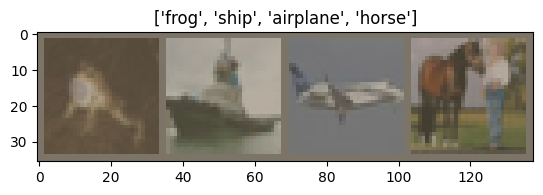

In [10]:
#取得した画像の確認
def imshow(inp, title=None):
    inp = inp.detach().numpy().transpose((1, 2, 0))  
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
#学習用の関数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 学習曲線を描画するためのデータを収集
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # ロスと精度を記録
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    # 学習曲線を描画
    plot_learning_curve(train_losses, val_losses, train_accs, val_accs)
    
    return model

In [12]:
#学習曲線描画用
def plot_learning_curve(train_losses, val_losses, train_accs, val_accs):
    if isinstance(train_losses[0], torch.Tensor):
        train_losses = [loss.item() for loss in train_losses]
        val_losses = [loss.item() for loss in val_losses]
        train_accs = [acc.item() for acc in train_accs]
        val_accs = [acc.item() for acc in val_accs]

    train_accs = [acc.cpu().numpy() for acc in train_accs]
    val_accs = [acc.cpu().numpy() for acc in val_accs]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
#モデル構造
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [14]:
#学習の設定
model_ft = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/29
----------
train Loss: 1.6069 Acc: 0.4116
val Loss: 1.2430 Acc: 0.5581

Epoch 1/29
----------
train Loss: 1.2895 Acc: 0.5409
val Loss: 1.0772 Acc: 0.6283

Epoch 2/29
----------
train Loss: 1.1649 Acc: 0.5878
val Loss: 0.9833 Acc: 0.6580

Epoch 3/29
----------
train Loss: 1.0848 Acc: 0.6158
val Loss: 0.9205 Acc: 0.6837

Epoch 4/29
----------
train Loss: 1.0362 Acc: 0.6336
val Loss: 0.9034 Acc: 0.6888

Epoch 5/29
----------
train Loss: 0.9978 Acc: 0.6466
val Loss: 0.8790 Acc: 0.6975

Epoch 6/29
----------
train Loss: 0.9699 Acc: 0.6595
val Loss: 0.8772 Acc: 0.7005

Epoch 7/29
----------
train Loss: 0.8311 Acc: 0.7073
val Loss: 0.7529 Acc: 0.7405

Epoch 8/29
----------
train Loss: 0.8006 Acc: 0.7166
val Loss: 0.7490 Acc: 0.7404

Epoch 9/29
----------
train Loss: 0.7828 Acc: 0.7239
val Loss: 0.7424 Acc: 0.7445

Epoch 10/29
----------
train Loss: 0.7777 Acc: 0.7261
val Loss: 0.7352 Acc: 0.7468

Epoch 11/29
----------
train Loss: 0.7634 Acc: 0.7320
val Loss: 0.7296 Acc: 0.7475

Ep

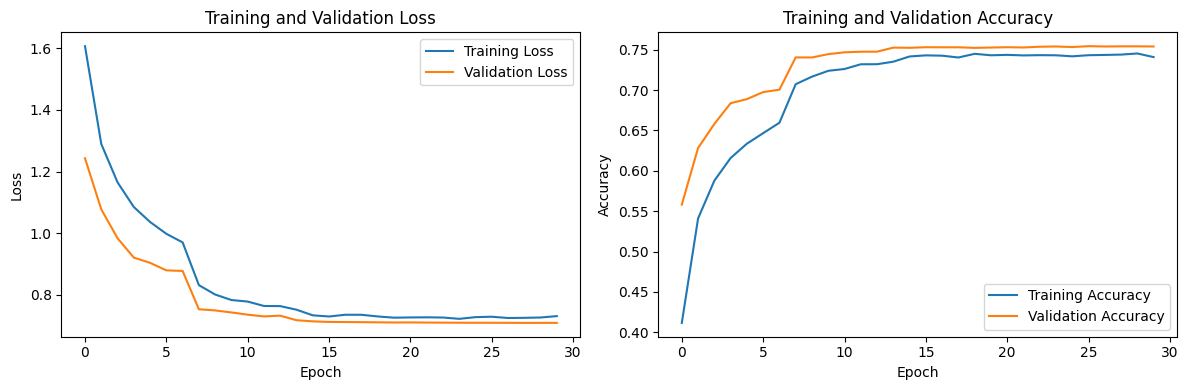

In [15]:
# 学習開始
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

# 保存したいモデルの状態辞書を取得
model_state_dict = model_ft.state_dict()

# 状態辞書をファイルに保存
torch.save(model_state_dict, "model.pth")

In [20]:
ds = torchvision.datasets.CIFAR10
input_transform = transforms.Compose([
    transforms.Resize(32, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_transform = transforms.Compose([
    transforms.Resize(32, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])

trainset = ds(root='data', train=True, download=True)

Files already downloaded and verified


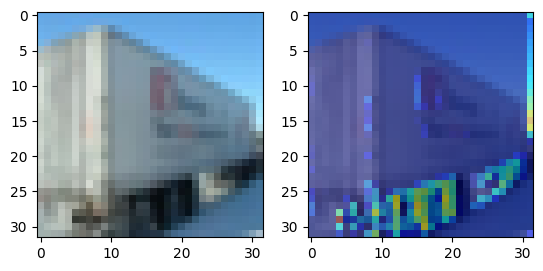

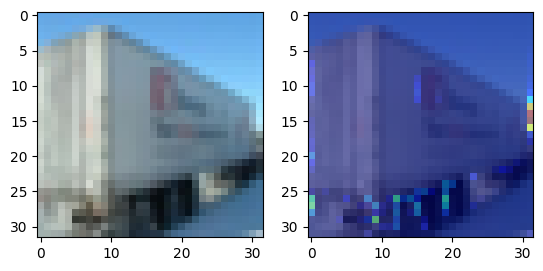

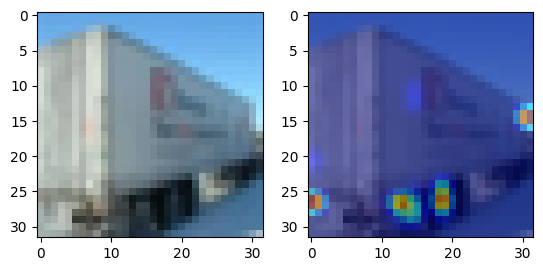

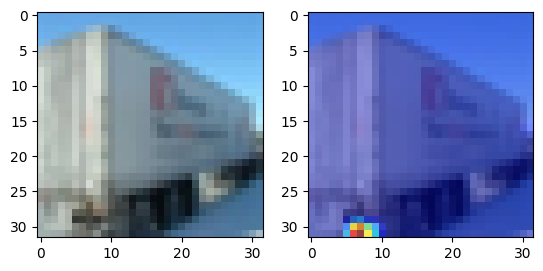

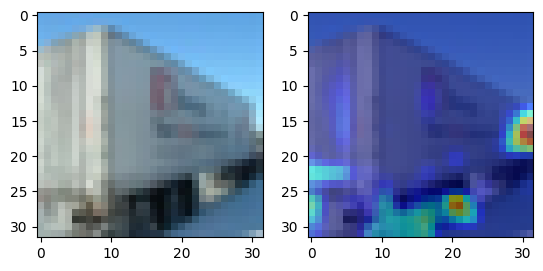

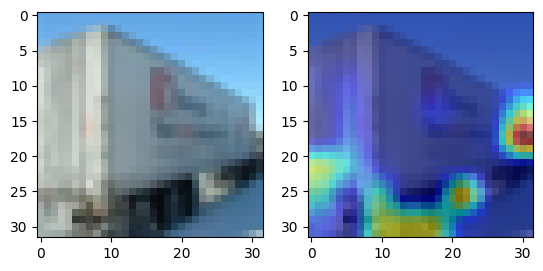

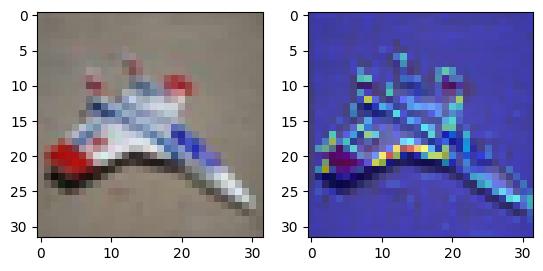

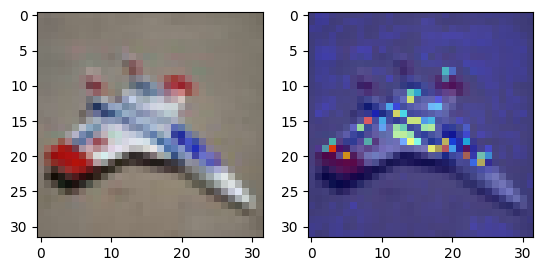

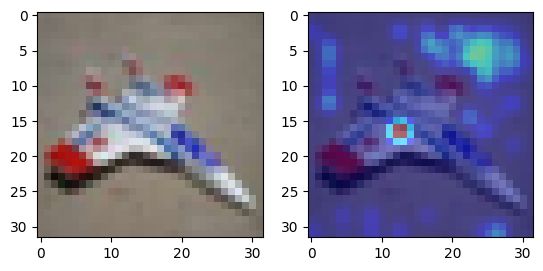

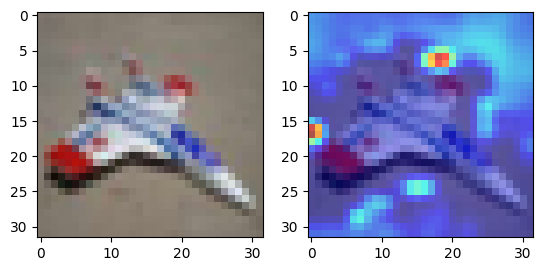

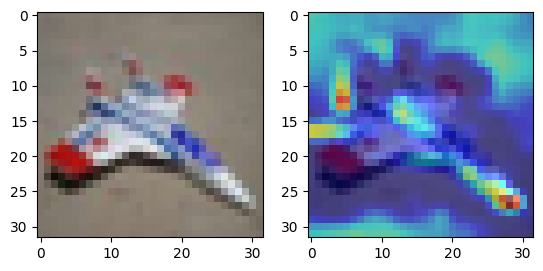

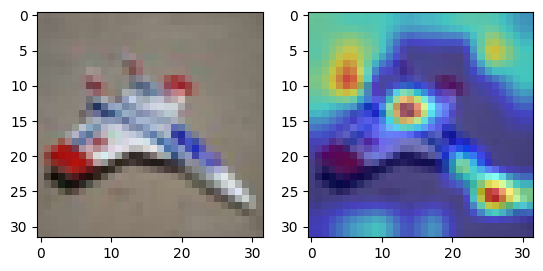

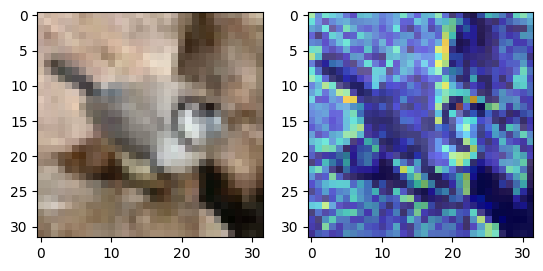

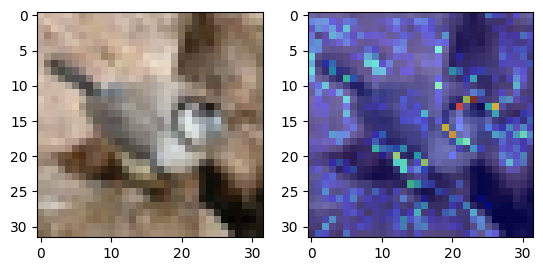

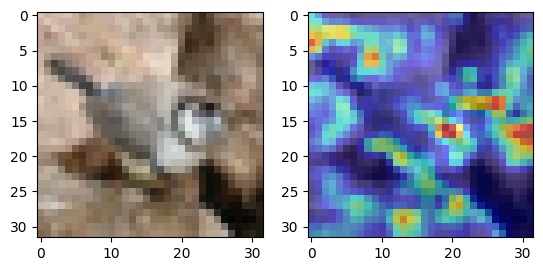

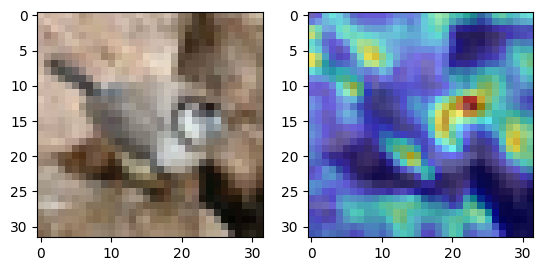

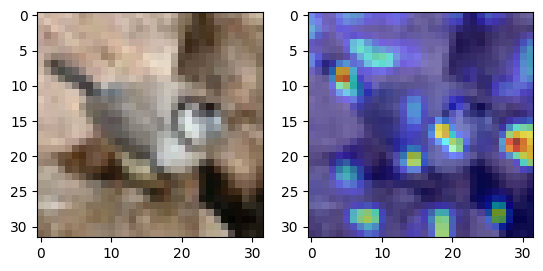

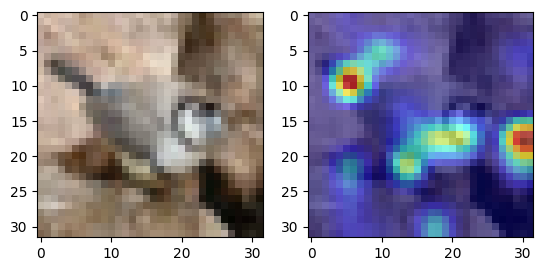

In [35]:
#特徴マップを一部表示
for x in [15, 30, 90]:
    img, label = trainset[x]
    input_img = input_transform(img)
    img = img_transform(img)
    for y in range(6):
        target_layers = [model_ft.features[y]]
        cam = GradCAM(
            model=model_ft, target_layers=target_layers, use_cuda=torch.cuda.is_available()
        )
        grayscale_cam = cam(
            input_tensor=input_img.unsqueeze(0),
            targets=[ClassifierOutputTarget(label)],
        )
        
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(img.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(img.permute(1, 2, 0).numpy())
        ax[1].imshow(visualization)